In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [2]:
#The dataset has 70000 images and each image has 784 features. This is because each images is 28 X 28 pixels and each pixel
#represents one pixels intensity from 0 (white) to 255 (black)
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
%matplotlib inline

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
some_digit=X[3]
some_digit_image=some_digit.reshape(28,28)

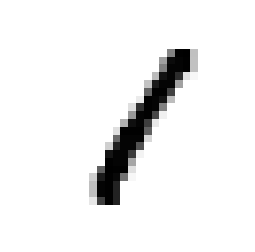

In [7]:
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[3]

'1'

## Splitting the Data into Training and Test Set

In [9]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## Shuffling the Dataset

In [10]:
import numpy as np

In [11]:
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

## Training a binary classifier

We will use the "5-detector"

In [12]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([False])

# Performance Measures

## Implementing Cross-Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [16]:
skfolds=StratifiedKFold(n_splits=3, random_state=42)

In [17]:
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0
0
0


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9588 , 0.9564 , 0.96105])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass

    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [20]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.90855, 0.9148 , 0.9056 ])

## Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [23]:
# from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53822,   757],
       [ 1718,  3703]])

## Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8302690582959641

In [25]:
recall_score(y_train_5,y_train_pred)

0.6830843017893378

In [28]:
#the F1 score combine the precion and recall.  it is the harmonic mean of the precision and recall
#NB: increasing precision reduces the  recision/recall tradeoff
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7495192794251594

## Precision and Recall Trade Off

In [29]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([-7693.23814531])

In [32]:
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [33]:
threshold=200000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [34]:
#Deciding on the threshold to use
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve
precisions,recalls, thresholds=precision_recall_curve(y_train_5,y_scores)

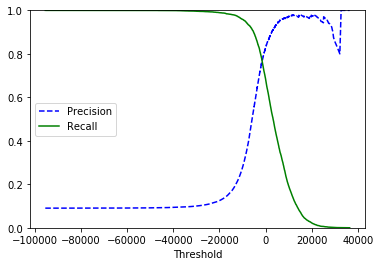

In [38]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [39]:
#if you decide to aim for a 90% precision, you will need to set a threshold of 70000. 
# insead of calling the predict method, you could use the following 

In [40]:
y_train_pred_90=(y_scores>70000)

In [41]:
precision_score(y_train_5,y_train_pred_90)

/home/yas/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [42]:
recall_score(y_train_5,y_train_pred_90)

0.0

## The ROC Curve

In [43]:
from sklearn.metrics import roc_curve

In [45]:
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

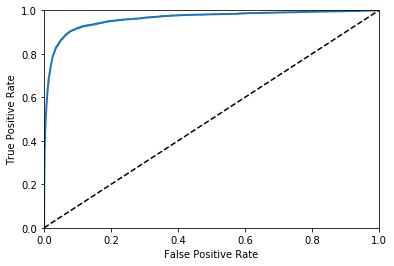

In [51]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9612583326740127

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [54]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,threshold_forest=roc_curve(y_train_5,y_scores_forest)

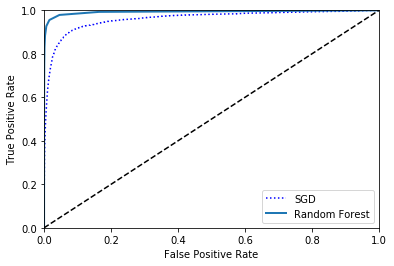

In [56]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()